In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.0/33.0 MB 20.7 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires flatbuffers<2,>=1.12, but you have flatbuffers 23.1.21 which is incompatible.


In [ ]:
import cv2 as cv
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import mediapipe
import pickle

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

* Module For loading faces from files then extract faces also resize images 
--> in which face net model recive images with targetsize ->> (160, 160) 

In [ ]:

class FACELOADING:

    def __init__(self, directory):
        self.directory = directory
        self.target_size = (160,160)
        self.X = []
        self.Y = []
        self.detector_model = mediapipe.solutions.face_detection
        self.detector = self.detector_model.FaceDetection(min_detection_confidence=0.6)
 
    # this code to perform face detection fro all images before 
    # pushing them into the model in the way of retraingig or Traformating learning -> based on giving images 
    # for face deteaction consadration i'll be using face detector by ->> Mediapipe 
    def extract_face(self, filename):
        # Reading images 
        img = cv.imread(filename)
        # transformaing images into RGB in the way media pipe model accept RGB Color 
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        
  
        # in this case take the width & height from the image 
        result = self.detector.process(img)
        # if there detection in which model detect the face for any image then this will give me the
        if result.detections:

          for face in result.detections:
            # then for each face detected with in 85% so process the under lines of code  
             if face.score[0] > 0.85 : 
              # boundary_box ->> containg face coardinate x ,y , w , h  
               bounding_box = face.location_data.relative_bounding_box

              #face coardinate x ,y , w , h -> represnting  in normalized manner 
              # in this case take the width & height from the image 
               width = img.shape[1]
               height = img.shape[0]
               # x min  * width -> turn to integer 
               x = int(bounding_box.xmin * width)
               # width with in bounding box * width -> turn to integer 
               w = int(bounding_box.width * width)
               # y min * height -> turn to integer 
               y = int(bounding_box.ymin * height)
               # height with in bounding box * ->|height turn to integer 
               h = int(bounding_box.height * height)  
               # just give me the face from over all image 
               face = img[y:y+h, x:x+w]
               # Resize the image into size of (160 , 160)
               face_arr = cv.resize(face, self.target_size)
               # return all resized face 
               return face_arr
    

    # loading faces from files or diractory | sub-diractory ->> 
    def load_faces(self, dir):
        FACES = []
        # extract image name form diractory where images are stored in .. 
        for im_name in os.listdir(dir):
          # try under line code 
            try:
                # give me images path contining diractory + image_name
                path = dir + im_name
                # then extract face from images using extract face method then store them into varibel 
                single_face = self.extract_face(path)
                # take extracted face into list named faces in which holds all extracted faces as resized array of each image 
                FACES.append(single_face)
                # if failled then pass return the faces list to the mehtod 
            except Exception as e:
                pass
        return FACES
    
    # extract class labels for the images which hold the first text of image name 
    def load_classes(self):
      # for sub diractores which are in main directory take each one  
        for sub_dir in os.listdir(self.directory):
            # path of sub diractory in which could extract images if they are in sub_dir 
            path = self.directory +'/'+ sub_dir+'/'
            # push the path into load faces method 
            FACES = self.load_faces(path)
            # extract image labels 
            labels = [sub_dir for _ in range(len(FACES))]
            # print if all images on the sub_dir are loaded 
            print(f"Loaded successfully: {len(labels)}")
            # push detected and resized faces into X varible 
            self.X.extend(FACES)
            # push extracted calsses into Y varible 
            self.Y.extend(labels)
        # return them as numpy array for faster and more efficent to store data 
        return np.asarray(self.X), np.asarray(self.Y)

    
    def plot_images(self):
        plt.figure(figsize=(18,16))
         
        for num,image in enumerate(self.X):
            if image is not None:
              ncols = 3
              nrows = len(self.Y)//ncols + 1
              plt.subplot(nrows,ncols,num+1)
              plt.imshow(image)
              plt.axis('off')

In [ ]:
faceloading = FACELOADING("/content/drive/MyDrive/traning_images")
X, Y = faceloading.load_classes()

Loaded successfully: 10
Loaded successfully: 5
Loaded successfully: 6
Loaded successfully: 7


<ipython-input-4-c267cc158395>:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(self.X), np.asarray(self.Y)


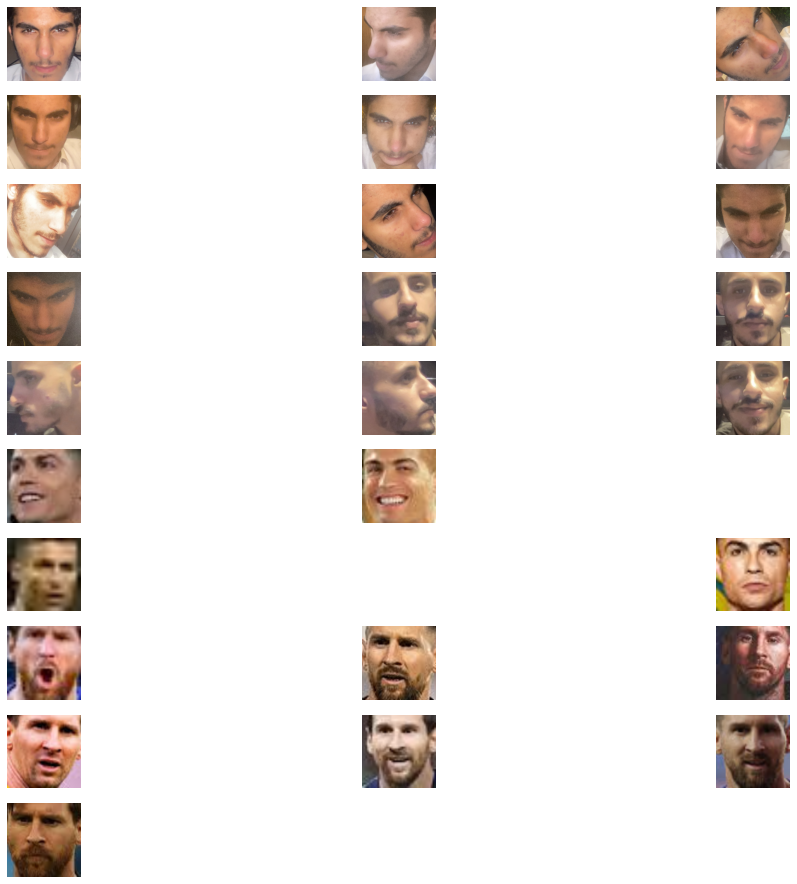

In [ ]:
faceloading.plot_images()

Downloading Keras Face-Net which mandtory for Using this Model  

In [ ]:
!pip install keras-facenet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 38.2 MB/s eta 0:00:00
  Created wheel for keras-facenet: filename=keras_facenet-0.3.2-py3-none-any.whl size=10386 sha256=abbf35aea70d591a73828c4074e72905251e8d3d5f26aca819cd43cceeb93442
  Stored in directory: /root/.cache/pip/wheels/dc/5f/3a/fa496ade459f1dcb2bdef3ad74cbdff2c90c28d09d6db39859
Successfully built keras-facenet


**EXTRACTING Faces embdinges** 

In [ ]:
from keras_facenet import FaceNet
embedder = FaceNet()

def get_embedding(face_img):
    face_img = face_img.astype('float64') # 3D(160x160x3) 
    face_img = np.expand_dims(face_img, axis=0)  
    # 4D (Nonex160x160x3)
    yhat= embedder.embeddings(face_img)
    return yhat[0] # 512D image (1x1x512)

In [ ]:
EMBEDDED_X = []

for img in X:
  if img is not None:
     EMBEDDED_X.append(get_embedding(img))

EMBEDDED_X = np.asarray(EMBEDDED_X)

1/1 [==============================] - 0s 70ms/step


In [ ]:
EMBEDDED_X

array([[ 0.05476533,  0.04456196,  0.0092431 , ...,  0.0108826 ,
        -0.01522965,  0.0467895 ],
       [ 0.03374378,  0.00380887,  0.00798656, ..., -0.04405274,
        -0.02719638,  0.03761283],
       [ 0.00544854, -0.01785773, -0.02365278, ...,  0.00580487,
        -0.0337019 , -0.03350654],
       ...,
       [ 0.01082248, -0.04158468, -0.03659111, ...,  0.0358303 ,
        -0.02969057, -0.0557982 ],
       [-0.00516949, -0.05007976, -0.05452118, ..., -0.00206588,
        -0.04025192, -0.05733888],
       [ 0.01800838, -0.05736852, -0.0334033 , ...,  0.05764655,
        -0.01888165, -0.07810275]], dtype=float32)

In [ ]:
np.savez_compressed('faces_embeddings_done_4classes.npz', EMBEDDED_X, Y)

In [ ]:
Y

array(['sly', 'sly', 'sly', 'sly', 'sly', 'sly', 'sly', 'sly', 'sly',
       'sly', 'abd', 'abd', 'abd', 'abd', 'abd', 'cr7', 'cr7', 'cr7',
       'cr7', 'cr7', 'cr7', 'messi', 'messi', 'messi', 'messi', 'messi',
       'messi', 'messi'], dtype='<U5')

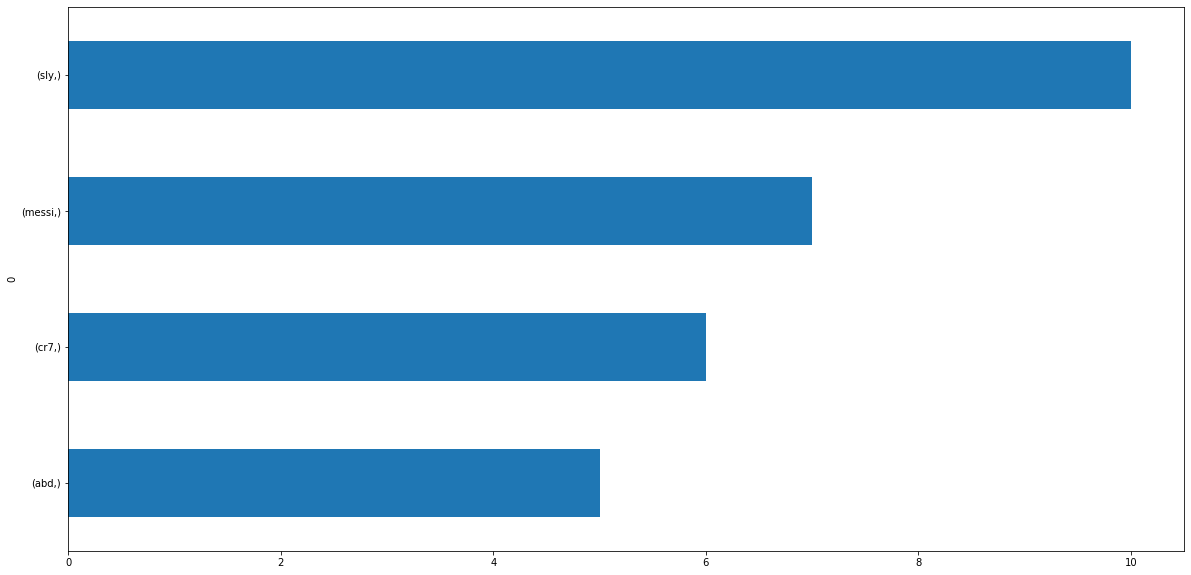

In [ ]:
pd.DataFrame(Y).value_counts().sort_values().plot(kind = 'barh' , figsize = (20,10))

In [ ]:
Y

array(['sly', 'sly', 'sly', 'sly', 'sly', 'sly', 'sly', 'sly', 'sly',
       'sly', 'abd', 'abd', 'abd', 'abd', 'abd', 'cr7', 'cr7', 'cr7',
       'cr7', 'cr7', 'cr7', 'messi', 'messi', 'messi', 'messi', 'messi',
       'messi', 'messi'], dtype='<U5')

In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(Y)
Y = encoder.transform(Y)

In [ ]:
Y

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 2])

In [ ]:
EMBEDDED_X.shape

(26, 512)

Text(0, 0.5, '3')

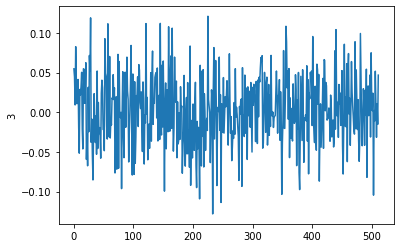

In [ ]:
plt.plot(EMBEDDED_X[0]) 
plt.ylabel(Y[0])

In [ ]:
# import random
# random.shuffle(Y)
Y = Y[:26]
Y.shape

(26,)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(EMBEDDED_X, Y ,test_size= 0.20 , random_state=0)

In [ ]:
from sklearn.svm import SVC
model = SVC(kernel='linear', probability=True)
model.fit(X_train, Y_train)



SVC(kernel='linear', probability=True)

In [ ]:
ypreds_train = model.predict(X_train)
ypreds_test = model.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(ypreds_test , Y_test) * 100 

66.66666666666666

In [ ]:
ypreds_test , Y_test

(array([3, 2, 0, 2, 3, 0]), array([3, 1, 0, 1, 3, 0]))

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


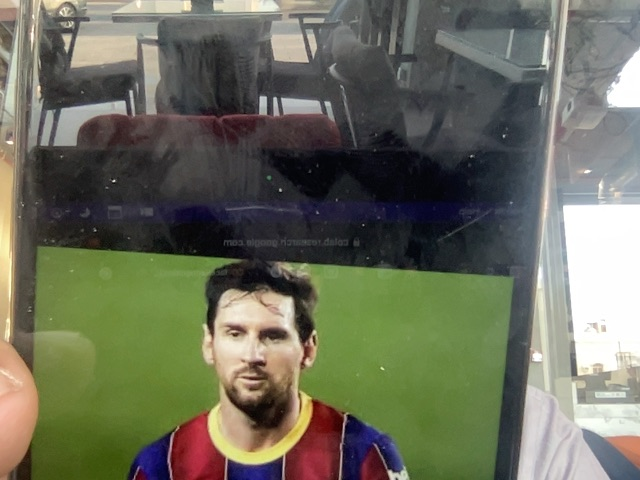

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

1/1 [==============================] - 0s 34ms/step


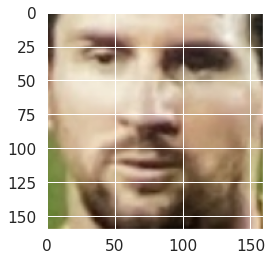

In [ ]:
# t_im = cv.imread("/content/photo.jpg")
# t_im = cv.cvtColor(t_im, cv.COLOR_BGR2RGB)
# x,y,w,h = detector.detect_faces(t_im)[0]['box']
 

# t_im = t_im[y:y+h, x:x+w]
# t_im = cv.resize(t_im, (160,160))
resized_img  = faceloading.extract_face("/content/photo.jpg") 
plt.imshow(resized_img)
test_im = get_embedding(resized_img)


test_im = [test_im]
ypreds =  model.predict(test_im)

In [ ]:
ypreds

array([2])

In [ ]:
encoder.inverse_transform(ypreds)[0]

'messi'

In [ ]:
# saving the model 
pickle.dump(model, open('model_2.pkl', 'wb'))
#loading pretrained model 
# pickled_model = pickle.load(open('model.pkl', 'rb'))
# pickled_model.predict(X_test)

Look like the model of prediction need some imporvment in case of recognition facese so 
let's use another model approch
->> base line model -- SVM  -- accuracy of the model 
- 85% let's improvet  

In [ ]:
# Model
from sklearn.ensemble import RandomForestClassifier
# Visualize Tree
from sklearn.tree import export_graphviz 




# Instantiate class. Using random_state=2 for you to be able to reproduce the same result
rf = RandomForestClassifier(n_estimators=1000, 
                            criterion='gini', 
                            max_depth=None, 
                            min_samples_split=2,
                            min_samples_leaf=1, 
                            min_weight_fraction_leaf=0.0,
                            max_features='auto',
                            max_leaf_nodes=None, 
                            min_impurity_decrease=0.0, 
                            bootstrap=True, 
                            oob_score=False, 
                            n_jobs=None, 
                            random_state=2, 
                            verbose=0, 
                            warm_start=False, 
                            class_weight=None, 
                            ccp_alpha=0.0, 
                            max_samples=None)





# Fit the model
rf.fit(X_train,Y_train)
# # Extract one of the trees from the model
# tree = rf.estimators_[99]



# # # Export as dot file
# # export_graphviz(tree, out_file='tree.dot',
# # feature_names = EMBEDDED_X, class_names = encoder.inverse_transform(Y), rounded = True, proportion = False, precision = 2, filled = True)
# # # Convert to png using system command (requires Graphviz)
# # from subprocess import call
# # call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=90'])
# # # Display in jupyter notebook
# # from IPython.display import Image
# # Image(filename = 'tree.png')




# # Get and reshape confusion matrix data
# import seaborn as sns
# import matplotlib.pyplot as plt
# matrix = confusion_matrix(Y_test, ypreds_test)
# matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# # Build the plot
# plt.figure(figsize=(16,7))
# sns.set(font_scale=1.4)
# sns.heatmap(matrix, annot=True, annot_kws={'size':10},
#             cmap=plt.cm.Greens, linewidths=0.2)

# # Add labels to the plot
# class_names = ['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine', 
#                'Cottonwood/Willow', 'Aspen', 'Douglas-fir',    
#                'Krummholz']
# tick_marks = np.arange(len(class_names))
# tick_marks2 = tick_marks + 0.5
# plt.xticks(tick_marks, class_names, rotation=25)
# plt.yticks(tick_marks2, class_names, rotation=0)
# plt.xlabel('Predicted label')
# plt.ylabel('True label')
# plt.title('Confusion Matrix for Random Forest Model')
# plt.show()



print(classification_report(Y_test, ypreds_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         0
           3       1.00      1.00      1.00         2

    accuracy                           0.67         6
   macro avg       0.50      0.50      0.50         6
weighted avg       0.67      0.67      0.67         6



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1

1/1 [==============================] - 0s 27ms/step


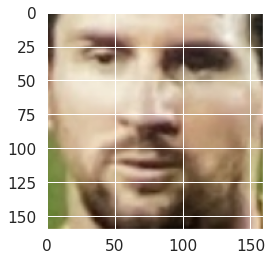

In [ ]:
# let's predict on this model 
resized_img  = faceloading.extract_face("/content/photo.jpg") 
plt.imshow(resized_img)
test_im = get_embedding(resized_img)


test_im = [test_im]
ypreds =  rf.predict(test_im)